# Figure 4

In [1]:
import sys
sys.path.insert(1, '../code/scripts')

In [2]:
## Basics
from scipy import stats
import numpy as np
import pandas as pd
import seaborn as sns
import mdtraj as md
import parseaf as pa
#import tempparse as paf

## Logistic regression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

## Plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
plt.rcParams.update({'font.size': 12})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = "Arial"

## Colors
cscheme = {'pos':'#0177BB', 'neg':'#CB3627', 'dis':'#828282', 'helix':'#009988', 'sheet':'#EE7733', 'cr':'#AA4499'}

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Functions

In [4]:
def get_aa_freq(seq, aa):
    cnt = 0
    for i in seq:
        if i == aa:
            cnt += 1
    aa_freq = cnt / len(seq)
    return aa_freq

In [5]:
def append_percent_aa(row, aa):
    seq = row['region_seq']
    if len(seq) == 0:
        print(row['uni_id'])
    return get_aa_freq(seq, aa)

In [6]:
def get_cnf_freq(cnf_mat):
    cnf_freq = cnf_mat / cnf_mat.sum(axis=1)[:, np.newaxis]
    return cnf_freq

## Data

In [7]:
allregions = pd.read_csv('../data/af_regions/sc_af_regions_all.csv')

In [8]:
df_all_orfs = pd.read_table('../data/sc_orfs/yeast-all-orfs.txt', header=None, names=['orf'])

In [9]:
all_orfs = df_all_orfs['orf'].tolist()

In [10]:
with open('../data/misc/uniprot-to-sgdid.txt') as f:
    mappings = {}
    for line in f:
        uniprot = line[95:106].rstrip()
        orf = line[75:95].rstrip()
        mappings[orf] = uniprot

In [11]:
len(allregions['uni_id'].unique()) / len(mappings)

0.635890573892358

In [12]:
len(allregions)

13437

In [13]:
cnf_df = pd.read_csv('../misc/cp_cnf_matrices_posttrim.csv')

In [14]:
cnf_df.head(5)

,FN,TP,TN,n,FP
0,41,1609,1598,4116,112
1,173,1462,1638,3915,132
2,26,301,326,619,28
3,524,1151,1955,4116,486
4,529,836,1948,3915,602


## 3A: Logistic regression model coefficients

In [15]:
states = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
          'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

In [16]:
for aa in states:
    allregions['freq_'+aa] = allregions.apply(lambda row: append_percent_aa(row, aa), axis=1)

In [17]:
featurecol = []
for aa in states:
    featurecol.append('freq_'+aa)
X = allregions[featurecol]
y = allregions['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
cnf_all = metrics.confusion_matrix(y_test, y_pred)
metrics.accuracy_score(y_test, y_pred)

0.9544642857142858

In [18]:
indices = list(y_test.index)
df_test = allregions[allregions.index.isin(indices)]
df_test.to_csv('../data/af_regions/sc_af_regions_testing.csv', index=False)

In [19]:
df_lr = pd.DataFrame(columns=['aa','coef'])
for i in range(20):
    df_lr = df_lr.append({'aa': states[i], 'coef': logreg.coef_[0][i]}, ignore_index=True)
df_lr = df_lr.sort_values(by='coef', ascending=False, key=abs)

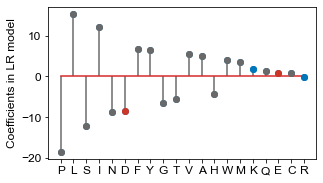

In [55]:
plt.figure(figsize=(4.8,2.8))
plt.stem(df_lr['aa'], df_lr['coef'],
         linefmt='dimgrey')

for index,row in df_lr.iterrows():
    aa = row['aa']
    if aa == 'K' or aa == 'R':
        color = cscheme['pos']
    elif aa == 'D' or aa == 'E':
        color = cscheme['neg']
    else:
        color = 'dimgrey'
    plt.scatter(aa, row['coef'], marker='o', color=color, zorder=3)
    
plt.ylabel('Coefficients in LR model')
plt.savefig('./plots/Figure4A.png', dpi=300, bbox_inches='tight')
plt.show()

## 3B: LR coefficients against helix propensity

In [24]:
df_hp = pd.read_csv('../data/misc/helix_propensity_pace1998.txt')
h_propensity = {}
for index, row in df_hp.iterrows():
    h_propensity[row['aa']] = row['hp']

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

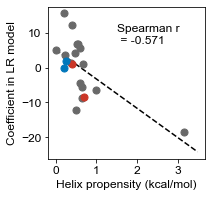

In [50]:
plt.figure(figsize=(2.8,2.8))

coefs = logreg.coef_.tolist()[0]
for i in range(20):
    aa = states[i]
    if aa == 'K' or aa == 'R':
        color = cscheme['pos']
        plt.scatter(h_propensity[aa], coefs[i],
                color=color, s=50, zorder=20)
    elif aa == 'D' or aa == 'E':
        color = cscheme['neg']
        plt.scatter(h_propensity[aa], coefs[i],
                color=color, s=50, zorder=20)
    else:
        color = 'dimgrey'
        plt.scatter(h_propensity[aa], coefs[i],
                color=color, s=50, zorder=3)

plt.xlabel('Helix propensity (kcal/mol)')
plt.ylabel('Coefficient in LR model')
corr = stats.spearmanr(list(h_propensity.values()), logreg.coef_[0].tolist())
reg = LinearRegression().fit(np.asarray(list(h_propensity.values())).reshape(-1, 1),
                             np.asarray(logreg.coef_[0].tolist()).reshape(-1, 1))
x = np.arange(0, 3.5, 0.01).reshape(-1, 1)
plt.plot(x, reg.predict(x), color='black', linestyle='--')

plt.text(1.5, 7, "Spearman r\n = " + '{0:.3g}'.format(corr.correlation))
#plt.savefig('./fig.png', dpi=300)
plt.savefig('./plots/Figure4B.png', dpi=300, bbox_inches='tight')
plt.show()

In [25]:
r2_score(np.asarray(logreg.coef_[0].tolist()).reshape(-1, 1),
         reg.predict(np.asarray(list(h_propensity.values())).reshape(-1, 1)))

0.4200079044178636

## 3C: Uversky plot for all regions

In [37]:
df = pd.read_csv('../data/uversky/uversky_all.csv')

In [38]:
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Helix',
                          markerfacecolor=cscheme['helix'], markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Disordered',
                          markerfacecolor=cscheme['dis'], markersize=10)]

In [39]:
X = np.asarray(df['norm_hydrop'].tolist())
Y = np.asarray(df['norm_nc'].tolist())

In [40]:
plot_idx = np.random.permutation(len(df))
labels = np.asarray(df['label'].tolist())
colors = pd.factorize(labels)

<Figure size 432x288 with 0 Axes>

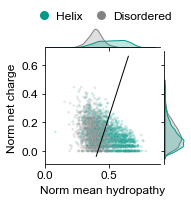

In [45]:
plt.figure()
g = sns.jointplot(X[plot_idx], Y[plot_idx], hue=labels[plot_idx],
                  palette={'disordered': cscheme['dis'], 'helix': cscheme['helix']},
                  alpha=0.2, s=7, height=2.5, legend=False)
x = np.linspace(0.4,0.65,100)
y = 2.785*x - 1.151
g.ax_joint.plot(x, y, 'black', linewidth = 1)
g.ax_joint.set_xlabel('Norm mean hydropathy')
g.ax_joint.set_ylabel('Norm net charge')
g.ax_joint.set_xlim(0, 0.9)

plt.legend(handles=legend_elements,handletextpad=0, columnspacing=0.5, ncol=2,
           bbox_to_anchor=(0.9, 1.45), frameon=False)
plt.savefig('./plots/Figure4C.png', dpi=300, bbox_inches = "tight")
plt.show()

## 3D: Accuracy of logistic regression model

In [56]:
cnf_matrices = []
sample_size = []
for index, row in cnf_df.iterrows():
    mat = np.array([[row['TN'], row['FP']], [row['FN'], row['TP']]])
    cnf_matrices.append(mat)
    if index < 3:
        sample_size.append(row['n'])

In [57]:
titles = ['Purely helical\nand disordered\nregions',
          'Randomly\ndrawn\nregions',
          'Highly\ncharged\nregions']

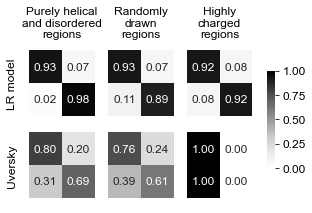

In [64]:
fig, axes = plt.subplots(2, 3, figsize=(4, 3), constrained_layout=False)
cbar_ax = fig.add_axes([0.95, .3, .03, .45])

for i, ax in enumerate(axes.flat):
    g = sns.heatmap(pd.DataFrame(get_cnf_freq(cnf_matrices[i])), ax=ax,
                    annot=True, fmt=".2f",
                    xticklabels=['', ''], yticklabels=['', ''],
                    cmap="Greys", cbar= (i == 0),
                    vmin=0, vmax=1,
                    cbar_ax=None if i else cbar_ax)
    g.tick_params(left=False, bottom=False)
    if i < 3:
        g.set_title(titles[i], fontsize=12, pad=5)
    #ax.title.set_position([.5, 0.8])
    if i == 0:
        ax.set_ylabel('LR model')
        ax.yaxis.labelpad = 5
    elif i == 3:
        ax.set_ylabel('Uversky')
        ax.yaxis.labelpad = 5
    bottom, top = ax.get_ylim()
    ax.set_aspect('equal', adjustable="datalim")
    #ax.set_ylim(bottom + 0.5, top - 0.5)

#plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.01)
plt.savefig('./plots/Figure4D.png', dpi=300, bbox_inches='tight')

## 3E: Summary of prediction accuracy for 3D

In [65]:
l_acc = []
for i in range(6):
    cnf = cnf_matrices[i]
    accuracy = (cnf[0, 0] + cnf[1, 1]) / np.sum(cnf)
    l_acc.append(accuracy)
sc_acc = np.mean(l_acc[:3])

In [66]:
ticks = ['LR model,\nall regions',
         'LR model,\nrandomly drawn regions',
         'LR model,\nhighly charged regions',
         'Uversky plot,\nall regions',
         'Uversky plot,\nrandomly drawn regions',
         'Uversky plot,\nhighly charged regions']

In [67]:
df_cnf = pd.DataFrame(columns=['model', 'dataset', 'l_acc'])

In [68]:
datasets = ['All regions', 'Random', 'Highly\ncharged']

In [69]:
for i in range(3):
    df_cnf = df_cnf.append({'model': 'LR', 'dataset':datasets[i], 'l_acc': l_acc[i]},
                           ignore_index=True)

In [70]:
for i in range(3):
    df_cnf = df_cnf.append({'model': 'Uversky', 'dataset':datasets[i], 'l_acc': l_acc[i+3]},
                           ignore_index=True)

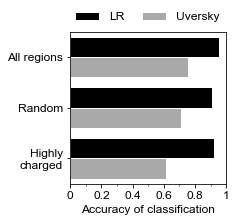

In [80]:
fig, ax = plt.subplots(figsize=(2.8,2.8))

sns.barplot(data=df_cnf, y='dataset', x='l_acc', hue='model',
            palette=['black', 'darkgrey'], edgecolor='white')
ax.set_xlabel('Accuracy of classification')
ax.set_ylabel('')
ax.set_xlim(0, 1)
ax.set_xticks(np.arange(0, 1.05, 0.2))
ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_xticks([0.1, 0.3, 0.5, 0.7, 0.9], minor=True)
plt.legend(title=None, ncol = 2, frameon=False, columnspacing=1.5,
           bbox_to_anchor=(1.025, 1.2))
plt.savefig('./plots/Figure4E.png', dpi=300, bbox_inches='tight')
plt.show()

## 3F: Prediction accuracy for other training or testing data

In [81]:
d_acc = {'sc_onlyP': 0.7401785714285715,
 'sc_onlyG': 0.5273809523809524,
 'sc_onlyPG': 0.7446428571428572,
 'sc_top5': 0.9282738095238096}

In [82]:
def change_width(ax, new_value) :
    #https://stackoverflow.com/questions/34888058/changing-width-of-bars-in-bar-chart-created-using-seaborn-factorplot
    for patch in ax.patches :
        
        current_height = patch.get_height()
        diff = current_height - new_value

        # we change the bar width
        patch.set_height(new_value)

        # we recenter the bar
        patch.set_y(patch.get_y() + diff * .5)

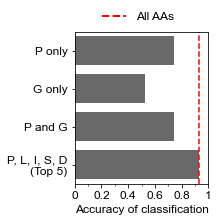

In [93]:
fig, ax = plt.subplots(figsize=(2.4,2.8))
keys = list(d_acc.keys())
vals = [d_acc[k] for k in keys]
ax = sns.barplot(y=keys, x=vals, color='dimgrey', ax=ax)
ax.set_yticklabels(['P only', 'G only', 'P and G','P, L, I, S, D\n(Top 5)'])
ax.set_xlabel('Accuracy of classification')
ax.set_xlim(0,1)
ax.set_xticks(np.arange(0, 1.05, 0.2))
ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_xticks([0.1, 0.3, 0.5, 0.7, 0.9], minor=True)
ax.axvline(sc_acc, color='red', linestyle='dashed')
ax.legend([Line2D([0], [0], color='red', lw=2, ls='dashed')],
           ['All AAs'],
          bbox_to_anchor=(0.82, 1.2), frameon=False)
change_width(ax, .75)
plt.savefig('./plots/Figure4F.png', dpi=300, bbox_inches='tight')
plt.show()

## 3G

In [85]:
d_acc2 = {'sc': sc_acc,
'pombe': 0.9320502749410841,
'human': 0.9699797453703703,
'celegans': 0.9530573847601129}

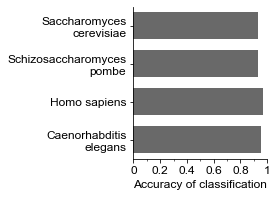

In [87]:
fig, ax = plt.subplots(figsize=(2.4,2.8))
keys = list(d_acc2.keys())
vals = [d_acc2[k] for k in keys]
sns.barplot(y=keys, x=vals, color='dimgrey')
ax.set_yticklabels(['Saccharomyces\ncerevisiae', 'Schizosaccharomyces\npombe', 'Homo sapiens', 'Caenorhabditis\nelegans'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim(0,1)
ax.set_xticks(np.arange(0, 1.05, 0.2))
ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_xticks([0.1, 0.3, 0.5, 0.7, 0.9], minor=True)
ax.set_xlabel('Accuracy of classification')
change_width(ax, .7)

plt.savefig('./plots/Figure4G.png', dpi=300, bbox_inches='tight')
plt.show()